Here we seek to solve
\begin{align}
\min_{(u,\rho)\in\mathcal{V}\times\mathcal{M}}J(u,\rho)&:=\frac{1}{2}\int_{\Omega}(u-u_{d})^{2}\mathrm{d}V+\frac{1}{2}R(\rho)\\
R(\rho)&:=\int_{\Omega}(\gamma_{1}\,\rho^{2}+\gamma_{2}\nabla \rho\cdot\nabla \rho)\mathrm{d}V
\end{align}

subject to the partial differential equality constraint

\begin{align*}
-\Delta u+\beta\, u&=\rho,\,\,\,\text{ in }\Omega \\
\frac{\partial u}{\partial n}&=0,\,\,\,\text{ on }\partial\Omega
\end{align*}

and bound constraint

\begin{align*}
\rho(x)\geq \rho_{\ell}(x)>0,\,\,\,\text{ on }\overline{\Omega}
\end{align*}

here $\beta\in\mathbb{R}$, $f:\Omega\rightarrow\mathbb{R}$, $u_{d}:\Omega\rightarrow\mathbb{R}$, $\rho_{\ell}:\overline{\Omega}\rightarrow\mathbb{R}_{>0}$, $\lbrace \gamma_{j}\rbrace_{j=1}^{2}\subset\mathbb{R}_{\geq 0}$ are given.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import dolfin as dl
# False - natural ordering; True - interlace
dl.parameters['reorder_dofs_serial'] = False


from filterLineSearchSparse import interior_pt
from hippylib import nb

from helperfunctions import *
from problems import inverseRHS


In [2]:
plt.style.use('classic')
plt.rcParams.update({'font.size': 16})

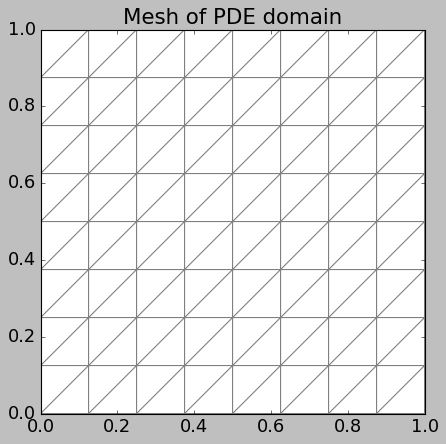

In [3]:
nx = 8 
    
mesh = dl.UnitSquareMesh(nx, nx)
dl.plot(mesh)
plt.title('Mesh of PDE domain')
plt.show()

In [4]:
P1 = dl.FiniteElement("CG", mesh.ufl_cell(), 1)
P2 = dl.FiniteElement("CG", mesh.ufl_cell(), 2)
Th = dl.MixedElement([P2, P1])
Vh = dl.FunctionSpace(mesh, Th)
Vh1 = dl.FunctionSpace(mesh, P1)
Vh2 = dl.FunctionSpace(mesh, P2)
print("dim(state) = {0:d}, dim(parameter) = {1:d}".format(Vh2.dim(), Vh1.dim()))

dim(state) = 289, dim(parameter) = 81


In [5]:
beta   = 1.
gamma1  = 1.e-6
gamma2 = 1.e-6
Crhol  = -15.
rhol  = dl.interpolate(dl.Expression('C', element=Vh1.ufl_element(), C=Crhol), Vh1).vector().get_local()
ud    = dl.interpolate(dl.Expression('std::cos(x[0]*pi)*std::cos(x[1]*pi)',\
                                          pi=np.pi, element=Vh2.ufl_element()), Vh2)
   
rhotrue = dl.interpolate(dl.Expression('C*std::cos(x[0]*pi)*std::cos(x[1]*pi)',\
                                      element=Vh1.ufl_element(), C= (beta+2.*np.pi**2), pi=np.pi), Vh1)
    
    
# initial point
x0 = np.array([1.+np.random.randn() if i < Vh2.dim() \
      else (abs(np.random.randn())+1. + rhol[i-Vh2.dim()]) for i in range(Vh.dim())])
    
problem = inverseRHS(Vh, Vh1, Vh2, beta, gamma1, gamma2, ud, rhol)

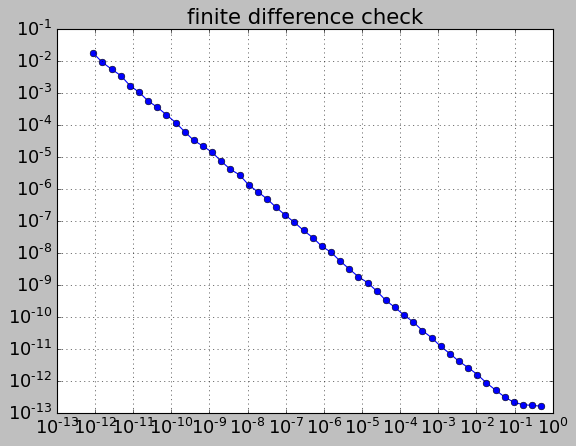

In [6]:
# ---- gradient check

epss  = np.logspace(1, 40, base=0.5)
     
F     = lambda x : problem.c(x)
gradF = lambda x : problem.Dxc(x)
F0   = F(x0)
gradF0   = gradF(x0)
xhat = np.random.randn(problem.n)
grad_err = np.zeros(len(epss))
for j, eps in enumerate(epss):
    Fplus = F(x0 + eps*xhat)
    if len(gradF0.shape) > 1:
        grad_err[j] = np.linalg.norm((Fplus - F0)/ eps - gradF0.dot(xhat), 2)
    else:
        grad_err[j] = np.abs((Fplus - F0) / eps - np.inner(gradF0, xhat))
plt.plot(epss, grad_err, '-ob')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title('finite difference check')
plt.show()


In [7]:
solver = interior_pt(problem)
x0      = np.ones(problem.n)
x0[:problem.n1] = problem.restore_feasibility(x0)
X0      = [x0, np.ones(problem.m), np.ones(problem.n2)]
solver.initialize(X0)
mu0 = 1.e0
tol = 1.e-12
max_it = 30
Xf, mu, E, Mus = solver.solve(tol, max_it, mu0)
xf, lamf, zf = Xf[:]

-------------------------------------------------- it = 0
-------------------------------------------------- determining search direction 
KKT sys error = 5.155e-14
NO INERTIA CORRECTION WAS REQUIRED
alpha = 1.000e+00, alphaz = 8.035e-01
in filter region?  False
A.5.4
theta(x) = 6.84e-14
angle between xhat and Dxphi = 113.1 (degrees)
descent direction?  True
theta(x) < theta_min?  True
step accepted A-5.4 CASE I
linesearch success?  True
accepted trial point for the subproblem
-------------------------------------------------- it = 1
solved barrier problem (mu = 1.000e+00)
solved barrier problem (mu = 5.000e-01)
-------------------------------------------------- determining search direction 
KKT sys error = 7.010e-14
NO INERTIA CORRECTION WAS REQUIRED
alpha = 1.000e+00, alphaz = 8.150e-01
in filter region?  False
A.5.4
theta(x) = 4.47e-14
angle between xhat and Dxphi = 105.0 (degrees)
descent direction?  True
theta(x) < theta_min?  True
step accepted A-5.4 CASE I
linesearch success?  T

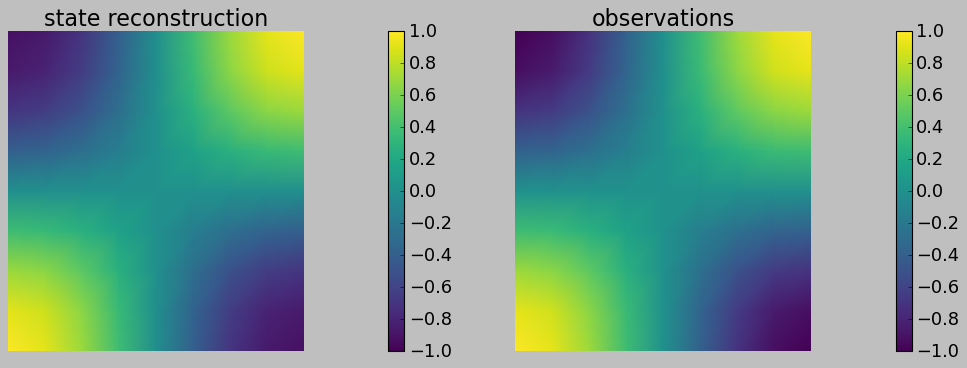

In [8]:
uReconstruction   = dl.Function(Vh2)
lamReconstruction = dl.Function(Vh2)

rhoReconstruction = dl.Function(Vh1)
zReconstruction   = dl.Function(Vh1)

uReconstruction.vector()[:]   = xf[:problem.n1]
rhoReconstruction.vector()[:] = xf[problem.n1:]

lamReconstruction.vector()[:] = lamf[:]
zReconstruction.vector()[:]   = zf[:]

nb.multi1_plot([uReconstruction, ud], ["state reconstruction", "observations"])
plt.show()

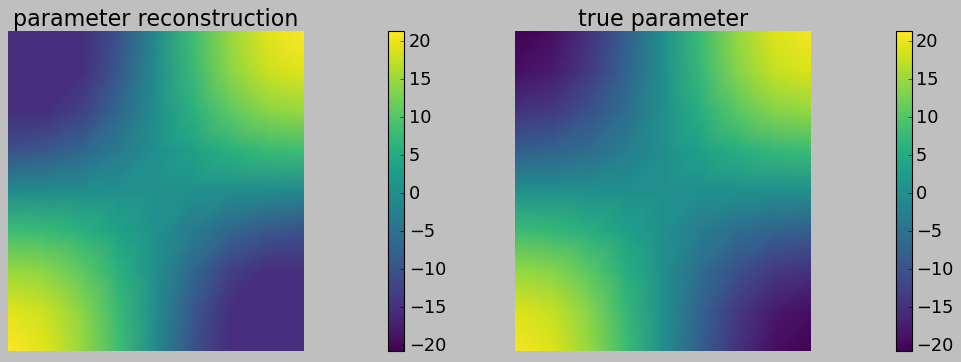

In [9]:
nb.multi1_plot([rhoReconstruction, rhotrue], ["parameter reconstruction", "true parameter"])
plt.show()

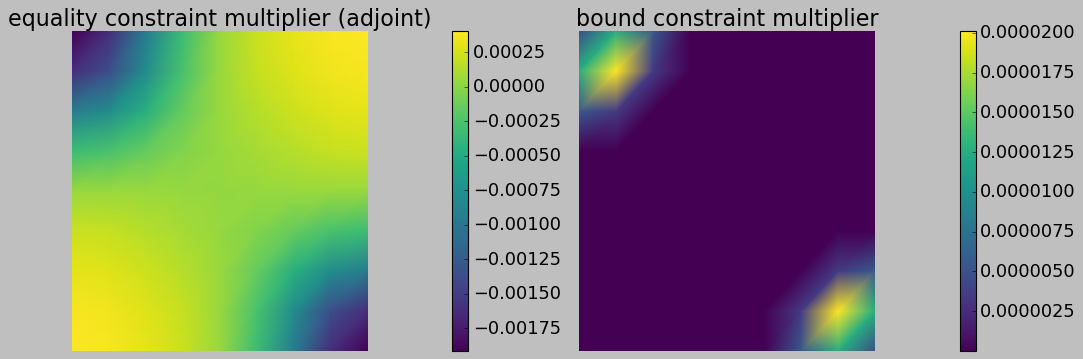

In [10]:
nb.multi1_plot([lamReconstruction, zReconstruction], \
            ["equality constraint multiplier (adjoint)", "bound constraint multiplier"],\
            same_colorbar=False)
plt.show()

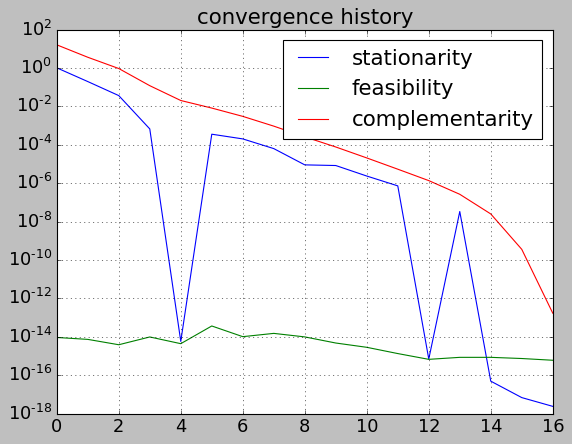

In [11]:
Es = [[E[i][j] for i in range(len(E))] for j in range(len(E[0]))]
labels = ["optimality error", "stationarity", "feasibility", "complementarity"]

for i in range(1,4):
    plt.plot(Es[i], label=labels[i])
    plt.yscale('log')
plt.legend()
plt.grid()
plt.title('convergence history')
plt.show()